In [1]:
import pandas as pd
import json
import random
import csv
import numpy as np
from datetime import datetime

In [2]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set(rc={'figure.figsize':(15,12)})

In [3]:
import subprocess
from IPython.display import Image

In [ ]:
def json_to_series(text):
    keys, values = zip(*[item for item in json.loads(text).items()])
    return pd.Series(values, index=keys)

# Random sample 90000 rows of training set

In [ ]:
filename = ".\\all\\train_v2.csv"

In [ ]:
n = sum(1 for line in open(filename,encoding="utf8")) - 1 

In [ ]:
s = 90000
skip = sorted(random.sample(range(1,1708337+1),1708337-s))
train_top = pd.read_csv(filename,skiprows=skip)

In [ ]:
train_top.to_csv("train_top.csv",index=False)

In [ ]:
df = pd.read_csv("train_top.csv")

# Data Cleaning

### Clean ID
sessionId = fullVisitorId_visitId    
visitNumber may be strong indicators since it means the visitor comes back multiple times

In [ ]:
ct = df.groupby(by='fullVisitorId')['visitId'].count()
visitn = df.groupby(by='fullVisitorId')['visitNumber'].max()
visitn = pd.concat([visitn,ct],axis=1)

In [ ]:
df.drop(['visitNumber','hits','trafficSource'],axis=1,inplace=True)

### Clean Totals

In [ ]:
df = pd.concat([df, df['totals'].apply(json_to_series)], axis=1)

In [ ]:
df.drop(['totals'],axis=1,inplace=True)

In [ ]:
#df['hits'] = df['hits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['pageviews'] = df['pageviews'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['newVisits'] = df['newVisits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['visits'] = df['visits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['bounces'] = df['bounces'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['transactionRevenue'] = df['transactionRevenue'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['totalTransactionRevenue'] = df['totalTransactionRevenue'].map(lambda x: int(x) if not pd.isnull(x) else 0)

In [ ]:
df.drop(['totalTransactionRevenue'],axis=1,inplace=True)

### Clean Time Series

In [ ]:
df['date'] = pd.to_datetime(df['date'],format="%Y%m%d")
df['week'] = df['date'].map(lambda x: x.isocalendar()[1])
df['day_of_week'] = df['date'].map(lambda x: x.isocalendar()[2])

In [ ]:
df.drop(['date'],axis=1,inplace=True)

In [ ]:
df["visitStartTime"] = df["visitStartTime"].map(lambda x:datetime.utcfromtimestamp(x).hour)

### Clean Location

In [ ]:
df = pd.concat([df, df['geoNetwork'].apply(json_to_series)], axis=1)

In [ ]:
df.drop(['geoNetwork'],axis=1,inplace=True)

### Clean Device

In [ ]:
df = pd.concat([df, df['device'].apply(json_to_series)], axis=1)

In [ ]:
df.drop(['device'],axis=1,inplace=True)

### Clean customDimensions

In [ ]:
df['customDimensions'] = df['customDimensions'].map(lambda x: x[1:-1])

In [ ]:
df['customDimensions'] = df['customDimensions'].map(lambda x: x.replace("'","\""))

In [ ]:
df.loc[df['customDimensions']=="",'customDimensions'] = "{\"index\":\"NaN\",\"value\":\"NaN\"}"

In [ ]:
df = pd.concat([df, df['customDimensions'].apply(json_to_series)], axis=1)

In [ ]:
df.drop(['customDimensions'],axis=1,inplace=True)

# Feature Cleaning

In [ ]:
ID = ["fullVisitorId","visitId"]

#### Drop uninformative categorical varibles

In [ ]:
for col in df.columns:
    cn = df[col].value_counts()
    if cn.shape[0]==1:
        df.drop(col,axis=1,inplace=True)

#### Drop variables with too many missing values

In [ ]:
df.replace("not available in demo dataset",np.NaN,inplace=True)

In [ ]:
df.replace("NaN",np.NaN,inplace=True)

In [ ]:
df.replace("(not set)",np.NaN,inplace=True)

In [ ]:
na_df = np.sum(df.isna(),axis=0)/df.shape[0]
na_df[na_df>0.1]

In [ ]:
df.drop(['index',"isMobile","transactions","metro"],axis=1,inplace=True)

# Fit and Compare Models

In [4]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,12 days 0 hours 27 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_Shuxinxu_hm5kr2
H2O cluster total nodes:,1
H2O cluster free memory:,1.347 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [5]:
Path = "train.csv"
df = pd.read_csv(Path)

In [8]:
names_y = "transactionRevenue"
ig_cols = ['fullVisitorId','visitId']

In [9]:
df[names_y] = df[names_y].map(lambda x:np.log(x+1))

In [10]:
given_types = {'channelGrouping':'enum', 'fullVisitorId':'numeric', 'visitId':'numeric', 'visitStartTime':'enum', 
               'hits':'numeric','pageviews':'numeric', 'timeOnSite':'numeric', 'newVisits':'enum', 
               'sessionQualityDim':'numeric','transactionRevenue':'numeric', 'bounces':'enum', 'week':'enum', 
               'day_of_week':'enum', 'continent':'enum','subContinent':'enum', 'country':'enum', 'region':'enum', 
               'city':'enum', 'networkDomain':'enum', 'browser':'enum','operatingSystem':'enum',
               'deviceCategory':'enum', 'value':'enum'}

In [11]:
train = h2o.H2OFrame(df,column_types=given_types)

/Users/Shuxinxu/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
types = train.types

In [13]:
cat = []
for key,value in types.items():
    if value == 'enum':
        cat.append(key)
print(cat)

['channelGrouping', 'visitStartTime', 'newVisits', 'bounces', 'week', 'day_of_week', 'continent', 'subContinent', 'country', 'region', 'city', 'networkDomain', 'browser', 'operatingSystem', 'deviceCategory', 'value']


In [14]:
names_x = list(types.keys())
names_x.remove("transactionRevenue")
names_x = [i for i in names_x if i not in ig_cols ]

In [15]:
train,test,te_holdout,valid = train.split_frame(ratios=[0.7,0.1,0.1])

### Random Forest with Enum Encoding

In [ ]:
drf0 = H2ORandomForestEstimator(ntrees=300, max_depth=8, nfolds=5,nbins_cats=5)

In [ ]:
drf0.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_drf = drf0.model_performance(train.rbind(valid)).mse()
test_mse_drf  = drf0.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_drf))
print("test_mse: {0:.3f}".format(test_mse_drf))

In [ ]:
drf0.varimp_plot()

### GBM with Enum Encoding

In [ ]:
gbm0 = H2OGradientBoostingEstimator(ntrees=300,max_depth=8,nfolds=5,nbins_cats=5,learn_rate=0.01,sample_rate=0.6)

In [ ]:
gbm0.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_gbm = gbm0.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm0.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

In [ ]:
gbm0.varimp_plot()

### GBM with sort_by_response Encoding

In [ ]:
gbm1 = H2OGradientBoostingEstimator(ntrees=300,max_depth=8,nfolds=5,nbins_cats=5,learn_rate=0.01,sample_rate=0.6,
categorical_encoding='sort_by_response')

In [ ]:
gbm1.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_gbm = gbm1.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm1.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

In [ ]:
gbm1.varimp_plot()

### GBM with Enum Encoding Channel/Device Analysis

In [16]:
sessionQuality = ['pageviews','sessionQualityDim','timeOnSite','hits']
names_x_sub = [i for i in names_x if i not in sessionQuality ]

In [17]:
gbm2 = H2OGradientBoostingEstimator(ntrees=300,max_depth=5,nfolds=5,nbins_cats=5,learn_rate=0.01,sample_rate=0.67,
                                   categorical_encoding='sort_by_response')

In [18]:
gbm2.train(x=names_x_sub,y=names_y,
             training_frame=train,
             validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
train_mse_gbm = gbm2.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm2.model_performance(test).mse()

In [36]:
prediction = gbm2.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

train_mse: 3.189
test_mse: 3.069


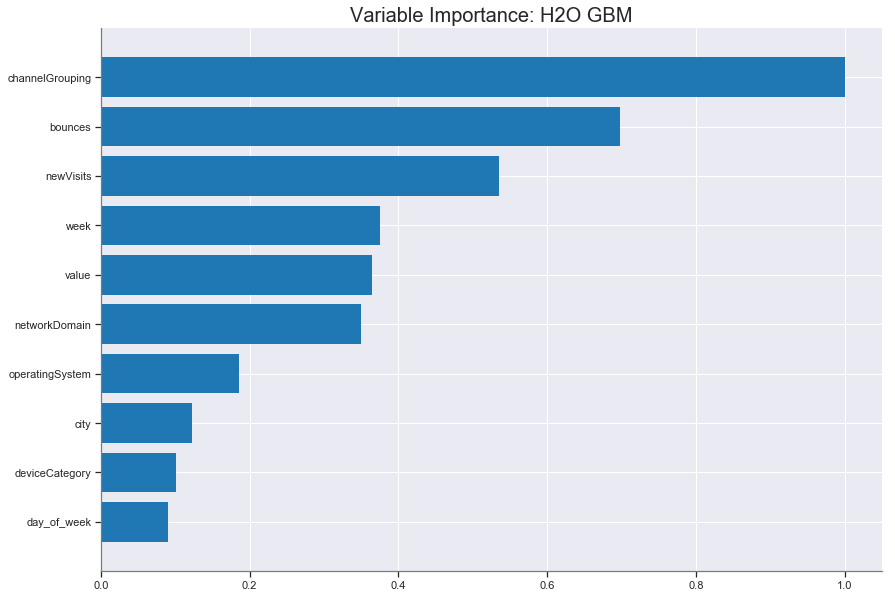

In [21]:
gbm2.varimp_plot()

In [60]:
#path = 'C://Users//XuL//Desktop//kaggle'
path=""
#mojo_file_name = '//model//gbm2.zip'
mojo_file_name = 'gbm2.zip'
#modelfile = gbm2.download_mojo(path+mojo_file_name,get_genmodel_jar=False)
modelfile = gbm2.download_mojo(mojo_file_name,get_genmodel_jar=False)
print("Model saved to " + modelfile)

Model saved to /Users/Shuxinxu/kaggle/Google_Analytics_Customer_Revenue_Prediction/kaggle/gbm2.zip


## Partial Dependency Plot

In [23]:
def lineplot_ci(pdp,x_name,ttl,cat_type,figsize=[10,6]):
    
    if cat_type=='int':
        pdp[x_name] = pdp[x_name].map(lambda x: int(x))
    elif cat_type=='float':
        pdp[x_name] = pdp[x_name].map(lambda x: float(x))
        
    pdp.sort_values(by=x_name,ascending=True,inplace=True)

    pdp['95%CI_lower'] = pdp['mean_response']-pdp['std_error_mean_response']*0.95
    pdp['95%CI_higher'] = pdp['mean_response']+pdp['std_error_mean_response']*0.95

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pdp[x_name],pdp['mean_response'],label='mean')
    ax.fill_between(pdp[x_name], pdp['95%CI_lower'],  \
                    pdp['95%CI_higher'], color='b', alpha=.1, label="95% CI")

    ax.scatter(pdp[x_name],pdp['mean_response'],color='r')
    ax.set_xticks(pdp[x_name])
    ax.legend(loc=0)
    ax.set_xlabel(ttl)
    ax.grid(True,linestyle='--')
    ax.set_title(ttl+" Partial Dependency Plot")
    
    return pdp

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


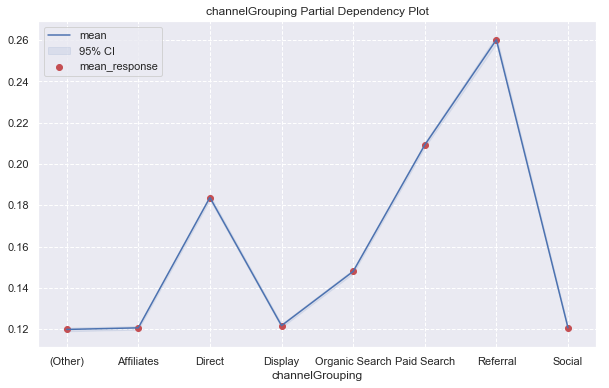

In [24]:
pdp = gbm2.partial_plot(train.rbind(valid),["channelGrouping"])
pdp = pdp[0].as_data_frame()
plt.close()
pdp_cg = lineplot_ci(pdp,"channelgrouping","channelGrouping",'str')

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


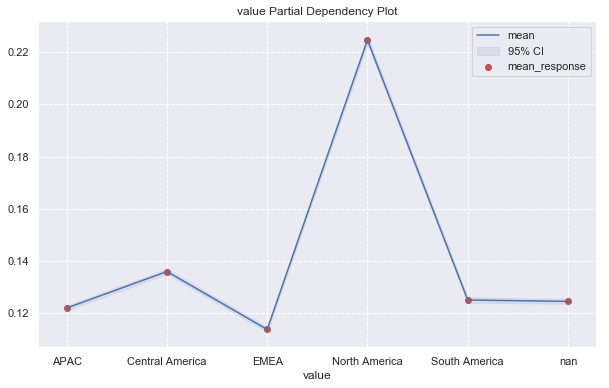

In [25]:
pdp = gbm2.partial_plot(train.rbind(valid),["value"],nbins=24)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"value".lower(),"value",'str')

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


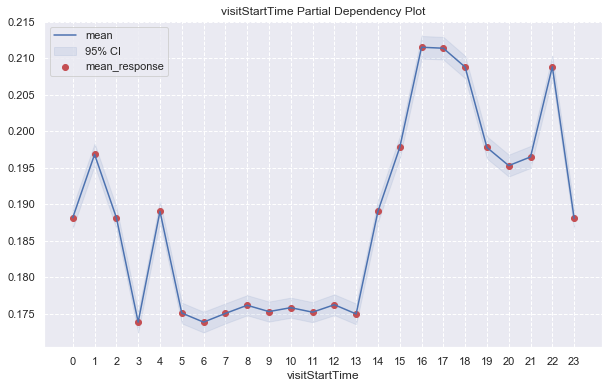

In [26]:
pdp = gbm2.partial_plot(train.rbind(valid),["visitStartTime"],nbins=24)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"visitStartTime".lower(),"visitStartTime",'int')

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


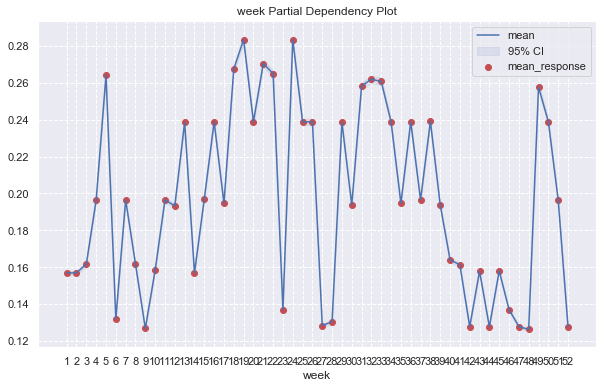

In [27]:
pdp = gbm2.partial_plot(train.rbind(valid),["week"],nbins=52)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"week","week",'int')

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


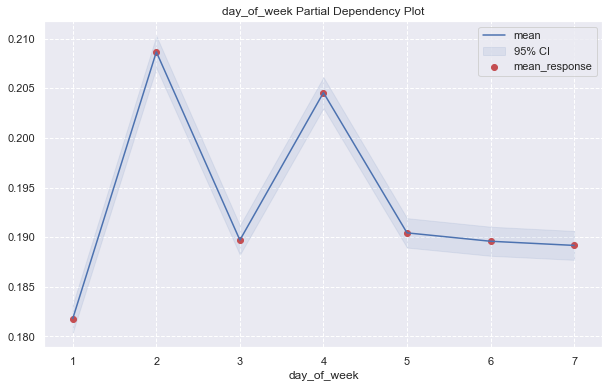

In [28]:
pdp = gbm2.partial_plot(train.rbind(valid),["day_of_week"],nbins=7)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"day_of_week","day_of_week",'int')

In [29]:
pdp = gbm2.partial_plot(train.rbind(valid),["operatingSystem"],nbins=19)
pdp = pdp[0].as_data_frame()
plt.close()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


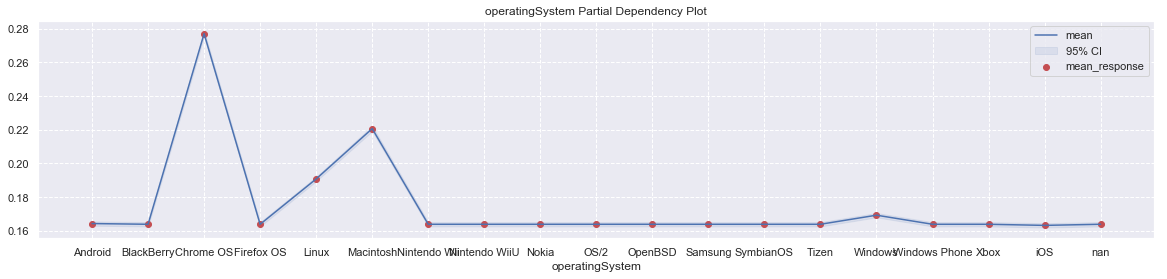

In [30]:
pdp = lineplot_ci(pdp,"operatingsystem","operatingSystem",'str',[20,4])

In [31]:
pdp = gbm2.partial_plot(train.rbind(valid),["deviceCategory"],nbins=7)
pdp = pdp[0].as_data_frame()
plt.close()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


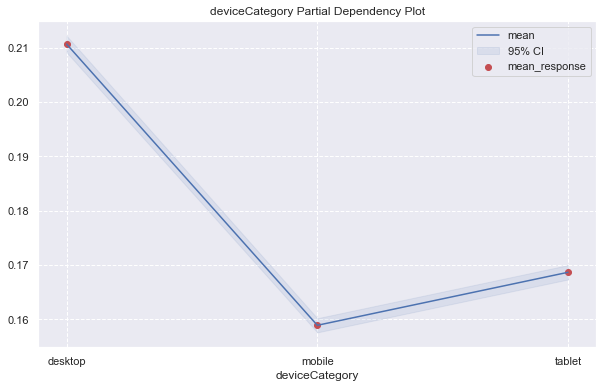

In [32]:
pdp = lineplot_ci(pdp,"devicecategory","deviceCategory",'str')

### Two Varaible PD Plot

In [40]:
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
pdp_day_of_week = pdp.pdp_isolate(
    model=gbm2, dataset=train.rbind(valid), model_features=names_x_sub, feature='day_of_week'
)
fig, axes = pdp.pdp_plot(pdp_day_of_week, 'day_of_week', plot_lines=True, frac_to_plot=100)

### Plot Major Decision Trees

In [76]:
h2o_jar_path= '../../../h2o/h2o.jar'
gv_file_path = "graph/my_gbm_graph"
image_file_path = "image/my_gbm_tree"

In [74]:
def generateTree(h2o_jar_path, mojo_file_path, gv_file_path, path, tree_id = 0):

    gv_file_path = path + gv_file_path + "_" + str(tree_id) + ".gv"
    mojo_file_path = path + mojo_file_path
    
    cmd = ["java", "-cp", h2o_jar_path, \
    "hex.genmodel.tools.PrintMojo", "--tree", str(tree_id), \
    "-i", mojo_file_path , "-o", gv_file_path ]
    
    result = subprocess.call(cmd, shell=False)
    print(" ".join(cmd))
    
    if result is 0:
        print("Success: Graphviz file " + gv_file_path + " is generated.")
    else: 
        print("Error: Graphviz file " + gv_file_path + " could not be generated.")

In [86]:
def generateTreeImage(gv_file_path, image_file_path, path, tree_id):
    
    image_file_path = path + image_file_path + "_" + str(tree_id) + ".png"
    gv_file_path = path + gv_file_path + "_" + str(tree_id) + ".gv"
    
    cmd = ["dot", \
                    "-Tpng", gv_file_path, "-o", image_file_path]
    print(" ".join(cmd))
   
    result = subprocess.call(cmd, shell=False)

    if result is 0:
        print("Success: Image File " + image_file_path + " is generated.")
        print("Now you can execute the follow line as-it-is to see the tree graph:") 
        print("Image(filename='" + image_file_path + "\')")
    else:
        print("Error: Image file " + image_file_path + " could not be generated.")

In [77]:
generateTree(h2o_jar_path,mojo_file_name,gv_file_path,path,0)

java -cp ../../../h2o/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i gbm2.zip -o graph/my_gbm_graph_0.gv
Success: Graphviz file graph/my_gbm_graph_0.gv is generated.


In [87]:
generateTreeImage(gv_file_path, image_file_path, path, 0)

dot -Tpng graph/my_gbm_graph_0.gv -o image/my_gbm_tree_0.png
Success: Image File image/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='image/my_gbm_tree_0.png')


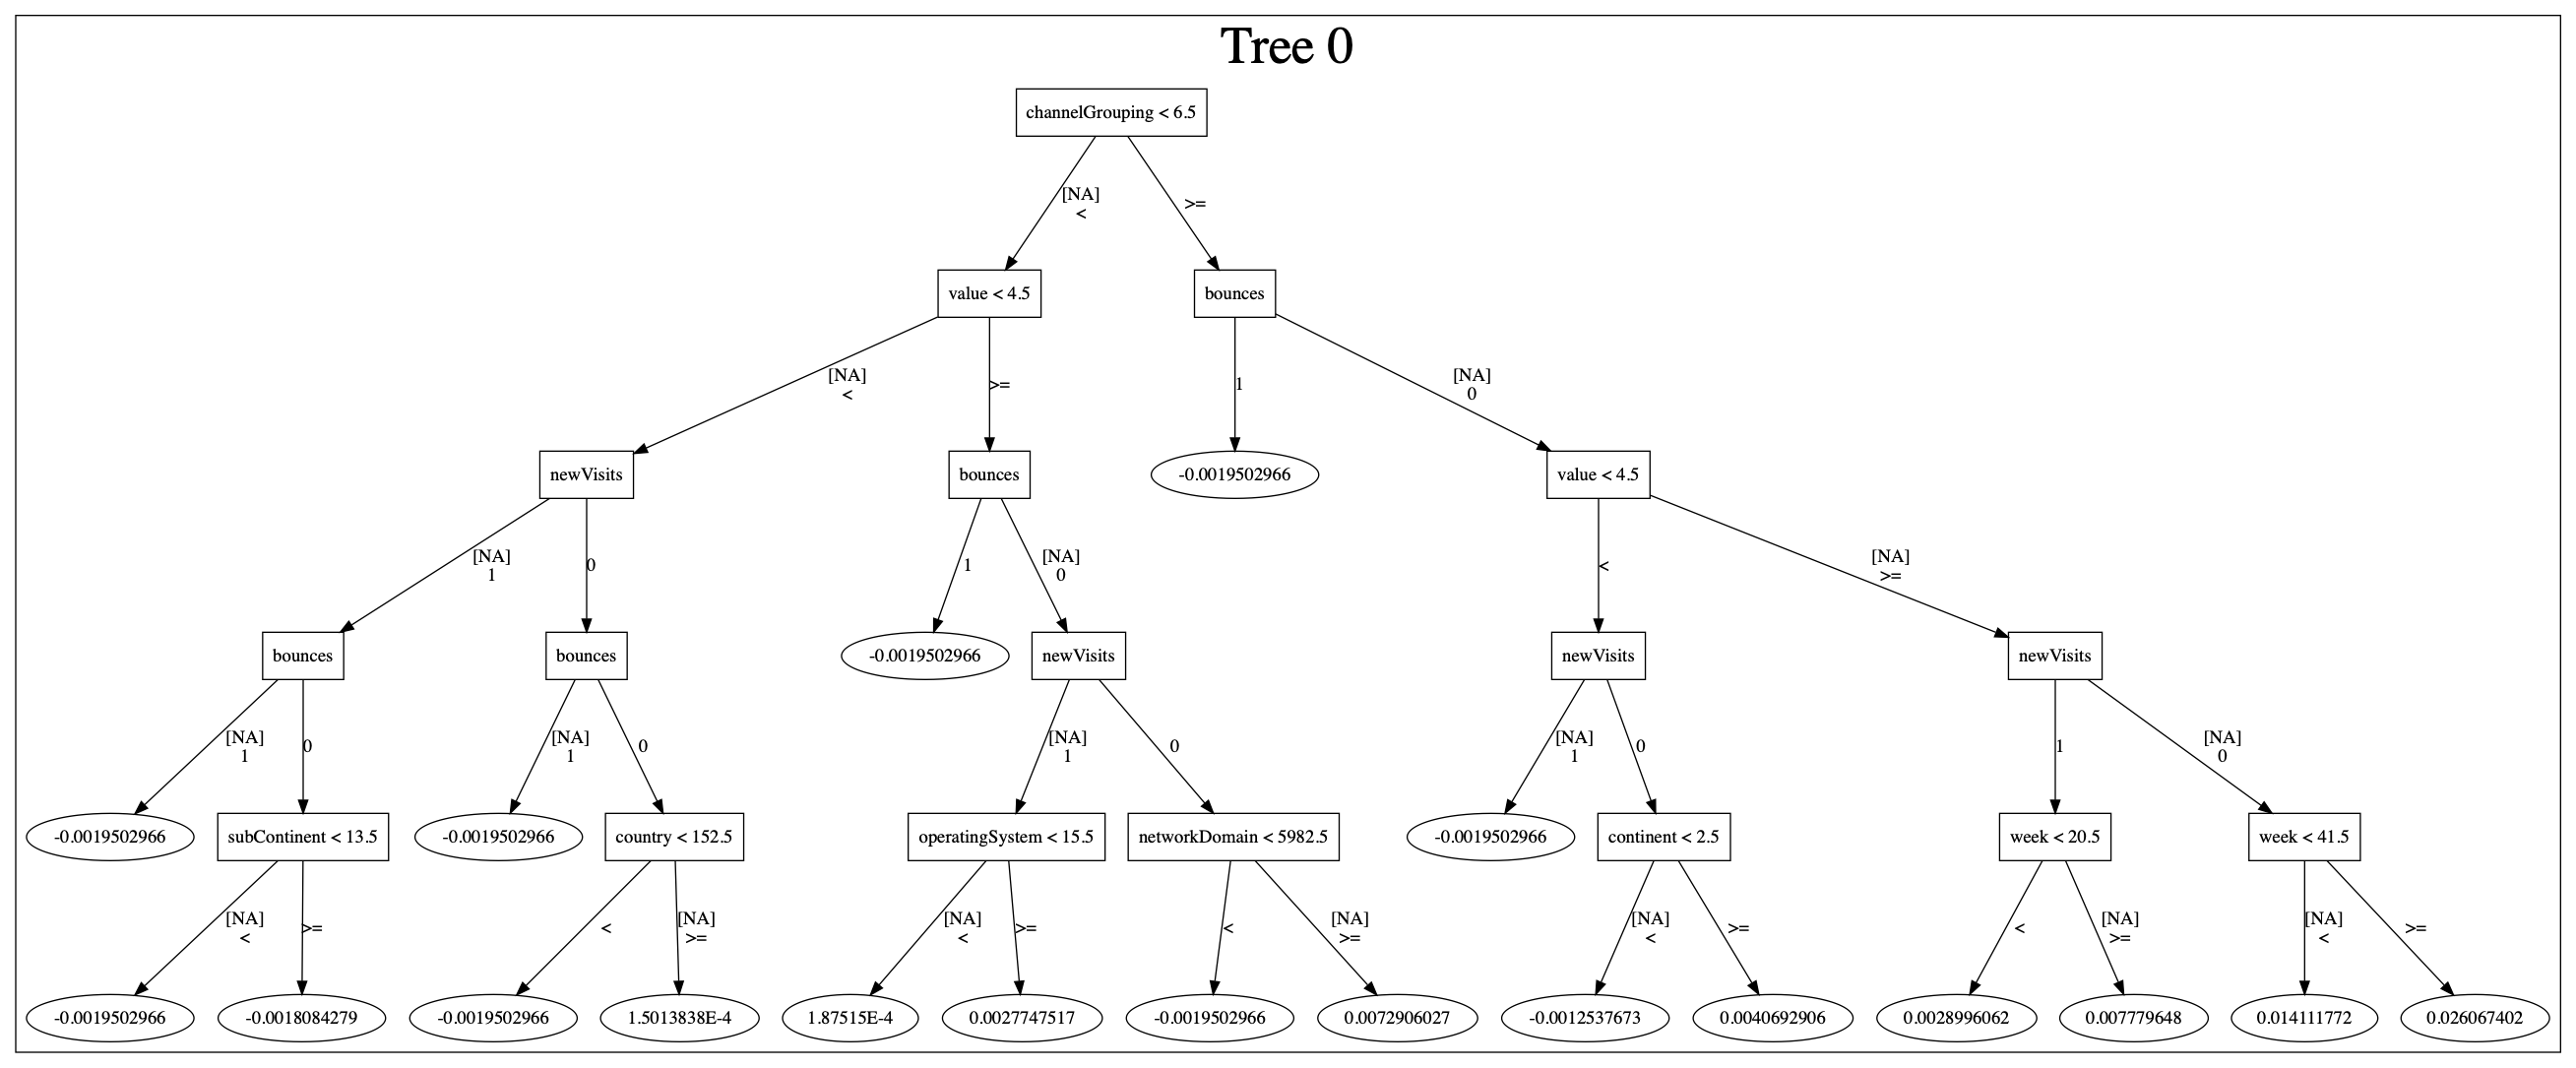

In [88]:
Image(filename=path+image_file_path+'_0.png')

In [90]:
generateTree(h2o_jar_path,mojo_file_name,gv_file_path,path,1)

java -cp ../../../h2o/h2o.jar hex.genmodel.tools.PrintMojo --tree 1 -i gbm2.zip -o graph/my_gbm_graph_1.gv
Success: Graphviz file graph/my_gbm_graph_1.gv is generated.


In [91]:
generateTreeImage(gv_file_path, image_file_path, path, 1)

dot -Tpng graph/my_gbm_graph_1.gv -o image/my_gbm_tree_1.png
Success: Image File image/my_gbm_tree_1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='image/my_gbm_tree_1.png')


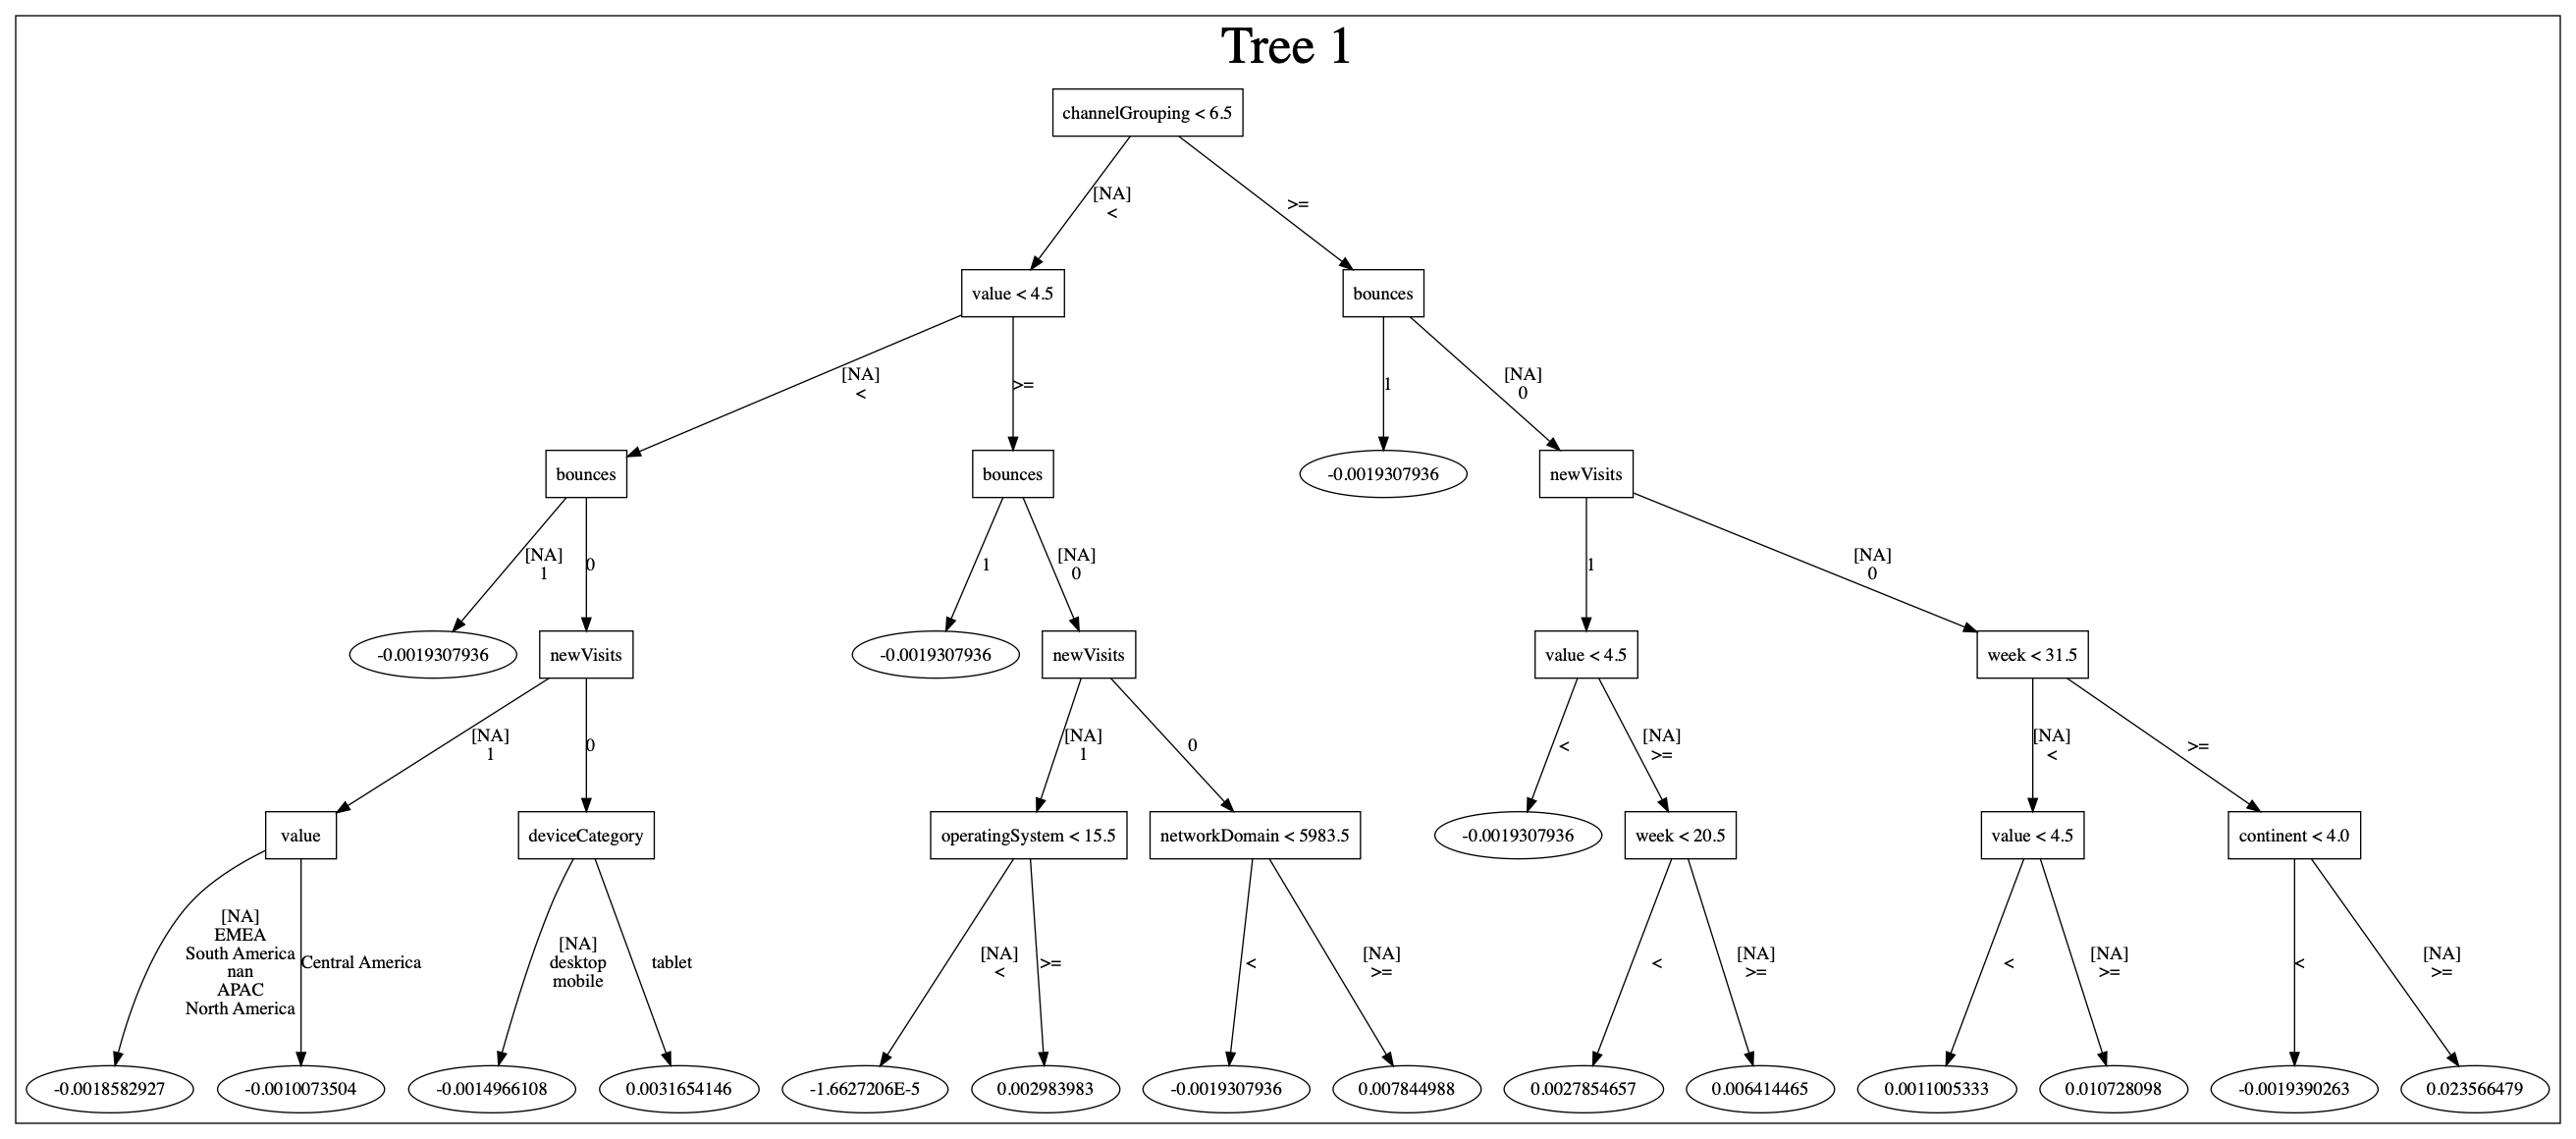

In [92]:
Image(filename=path+image_file_path+'_1.png')

# Data Analysis and Visualization

In [104]:
df["log_pageviews"] = df["pageviews"].map(lambda x: np.log(x+0.001))

In [110]:
df['is_referral'] = df['channelGrouping'].map(lambda x: 1 if x=="Referral" else 0)

In [105]:
df["log_sessionQualityDim"] = df["sessionQualityDim"].map(lambda x: np.log(x+0.001) if not pd.isnull(x) else x)

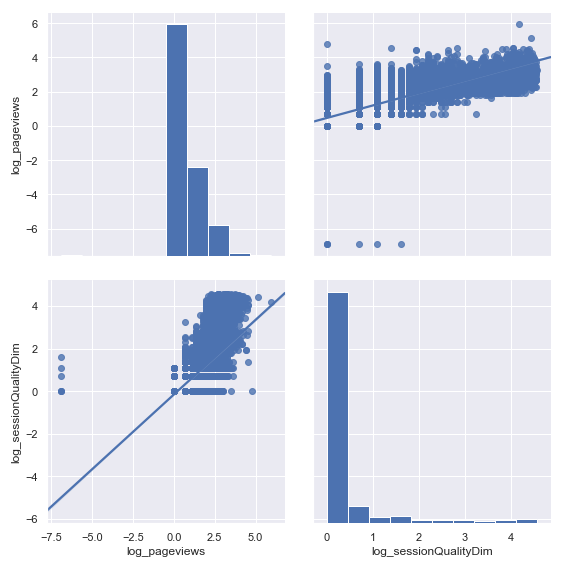

In [128]:
seaborn.pairplot(df.loc[~pd.isnull(df["log_sessionQualityDim"])], 
                 vars=["log_pageviews", "log_sessionQualityDim"],
                 kind="reg",dropna=True,height=4)

## How to interpret targe value encoding for Cat Variables for Variance Importance Plot?
Not acurate; biased towards high cardinality

## How to group cat variables with high cardinality for visualization?

## PDF Box Interprete partial dependence plot

## Remove Outliers

## Grid Search